<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/355_groups_comparison.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(groups_comparison_notebook)=
# Confronto tra gruppi

L'obiettivo di questo capitolo è di ampliare la discussione del capitolo {ref}`bayes_one_mean_notebook`, affrontando il confronto tra le medie di due o più gruppi indipendenti.  Per cominciare, carichiamo le librerie necessarie.

In [1]:
from pymc import HalfNormal, HalfCauchy, Model, Normal, sample
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Stima della media di un gruppo

Iniziamo con l'utilizzo del caso precedentemente trattato nel capitolo precedente, in cui abbiamo calcolato l'incertezza relativa alla media di un singolo gruppo. Qui useremo i dati relativi ai pinguini Palmer, che verranno letti da un file csv, escludendo quelli che presentano valori mancanti:

In [7]:
penguins = pd.read_csv("data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape


(333, 8)

Otteniamo in questo modo un DataFrame con 333 righe e 8 colonne. Calcoliamo la media del peso `body_mass_g` in funzione della specie:

In [8]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)


body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Creiamo un grafico a violino per questi dati.

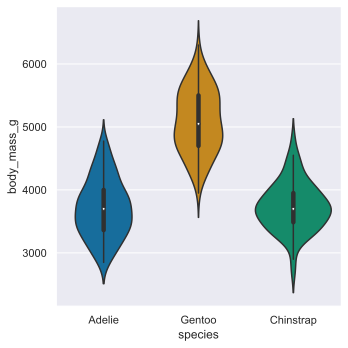

In [9]:
_ = sns.catplot(kind="violin", data=penguins, x="species", y="body_mass_g")


Fino ad ora abbiamo analizzato un campione di osservazioni. Tuttavia, la stima della media e della varianza ottenuta dal campione non è rappresentativa dell'intera popolazione di pinguini. Ci chiediamo, quindi, quale sia l'incertezza associata alla stima del peso per le tre specie di pinguini, considerando che abbiamo a disposizione solo un piccolo campione di osservazioni.

Una possibile soluzione per quantificare l'incertezza della nostra stima è l'utilizzo dei metodi bayesiani.

Per fare ciò, dobbiamo definire un modello statistico che descriva la relazione tra i dati e i parametri. Nel nostro caso, descriviamo la distribuzione a posteriori dei parametri, tenendo conto dei dati, come segue:

$$
p(\mu, \sigma \mid y) \propto p(y \mid \mu, \sigma) p(\mu)p(\sigma),
$$

dove la verosimiglianza sarà una densità Normale, dipendente da due parametri: $\mu$ e $\sigma$. Inoltre, per definire le distribuzioni a priori di questi due parametri, useremo una distribuzione Normale per $\mu$ ($\mu \sim \mathcal{N}(4000, 2000)$) e una distribuzione Normale troncata per $\sigma$ (valori negativi sono impossibili: $\sigma \sim \mathcal{HN}(2000)$).

Per esempio, selezioniamo solo i pinguini della specie Adelie. I valori della variabile `body_mass_g` relativi a questa specie sono:

In [10]:
adelie_mass_obs = penguins[penguins["species"] == "Adelie"]["body_mass_g"]
print(adelie_mass_obs)


0      3750.0
1      3800.0
2      3250.0
4      3450.0
5      3650.0
        ...  
147    3475.0
148    3450.0
149    3750.0
150    3700.0
151    4000.0
Name: body_mass_g, Length: 146, dtype: float64


Per implementare il modello descritto in precedenza, utilizzeremo PyMC. 

Prima di eseguire il campionamento della distribuzione a posteriori, esamineremo la distribuzione predittiva a priori per verificare l'adeguatezza delle assunzioni relative alle distribuzioni a priori dei parametri. Per fare ciò, useremo la funzione `pm.sample_prior_predictive()`, che ci permetterà di generare 1000 valori casuali dalle distribuzioni a priori dei due parametri.

In [11]:
with pm.Model() as model_adelie_penguin_mass:
    sigma = pm.HalfNormal("sigma", sigma=1000)
    mu = pm.Normal("mu", 4000, 2000)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mass_obs)

    idata1 = pm.sample_prior_predictive(samples=1000, random_seed=rng)


Sampling: [mass, mu, sigma]


Dall'oggetto inferenceData `idata1` recuperiamo i campioni delle distribuzioni a priori e li passiamo a `az.plot_trace()`:

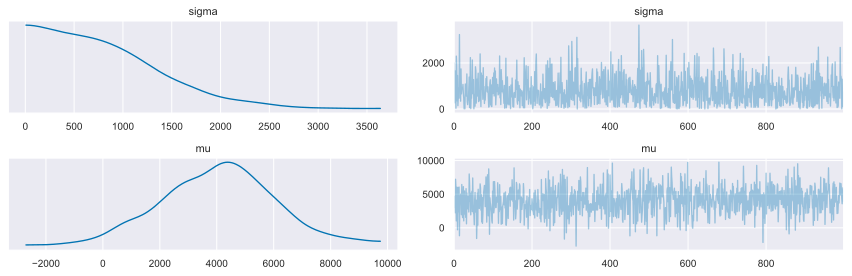

In [12]:
prior = idata1.prior
_ = az.plot_trace(prior)
plt.tight_layout()


Dall'osservazione delle distribuzioni a priori dei due parametri, si può notare che non stiamo limitando troppo il campionamento della variabile `adelie_mass_obs`. Potremmo persino aver scelto distribuzioni a priori troppo ampie, dato che la distribuzione a priori per $\mu$ include anche valori negativi. Tuttavia, poiché questo è un modello semplice e abbiamo un numero sufficiente di osservazioni, non c'è bisogno di preoccuparsi. Possiamo procedere con la stima della distribuzione a posteriori.

In [13]:
with pm.Model() as model_adelie_penguin_mass:
    
    sigma = pm.HalfNormal("sigma", sigma=1000)
    mu = pm.Normal("mu", 4000, 2000)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mass_obs)

    idata2 = pm.sample(3000, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 24 seconds.


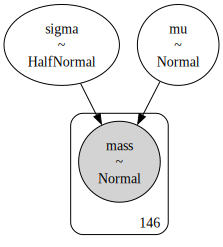

In [14]:
pm.model_to_graphviz(model_adelie_penguin_mass)

Il KDE plot e il rank plot della distribuzione a posteriori dei parametri del modello bayesiano ci aiutano a diagnosticare eventuali problemi durante il campionamento in modo visivo. Tuttavia, in questo caso, non ci sono segnali di problemi durante il campionamento.

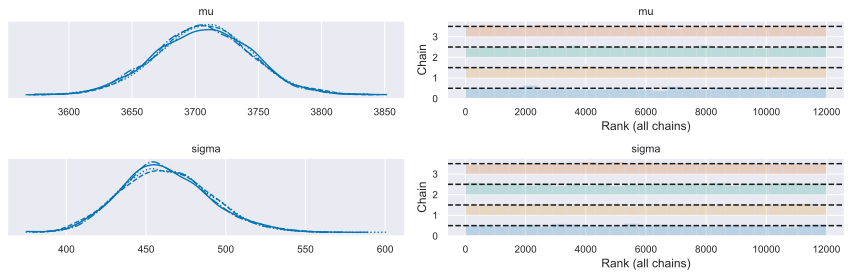

In [15]:
axes = az.plot_trace(idata2, divergences="bottom", kind="rank_bars")
plt.tight_layout()


Possiamo unire le quattro catene ottenute dal campionamento e utilizzarle per fare una stima più precisa dei parametri $\mu$ e $\sigma$ della distribuzione a posteriori. 

Nella figura seguente possiamo vedere un confronto tra la distribuzione a posteriori stimata e le stime puntuali dei due parametri che abbiamo ottenuto dal campione. Le linee verticali indicano i valori puntuali stimati per $\mu$ e $\sigma$, mentre la curva rappresenta la distribuzione a posteriori stimata attraverso il campionamento delle catene. 

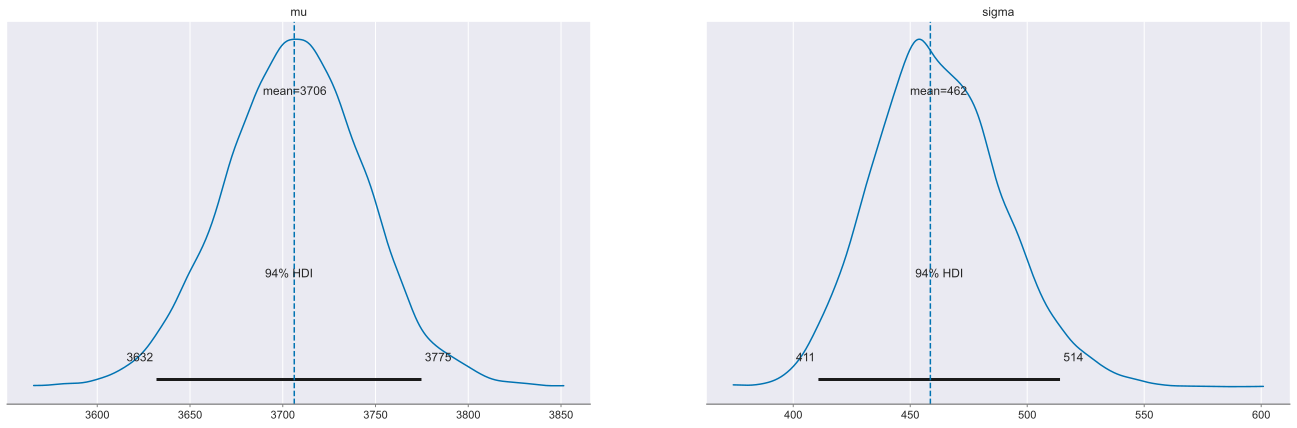

In [16]:
axes = az.plot_posterior(idata2, hdi_prob=0.94)

axes[0].axvline(3706.2, linestyle="--")
axes[1].axvline(458.6, linestyle="--")


La stima bayesiana ci fornisce una distribuzione dei valori plausibili dei parametri. Le distribuzioni a posteriori ottenute per $\mu$ e $\sigma$ ci indicano il valore più credibile, ma anche la gamma di valori in cui ci si può aspettare che si trovi il "vero" valore del parametro, considerando differenti campioni di osservazioni. L'intervallo di valori plausibili è abbastanza stretto sia per $\mu$ (tra 3634 e 3778), che per $\sigma$ (94% HDI: [412, 513]).

In definitiva, le due distribuzioni a posteriori descrivono l'incertezza che abbiamo relativamente ai veri valori di $\mu$ e $\sigma$, tenendo in considerazione le nostre credenze precedenti (in questo caso, distribuzioni a priori debolmente informative, utilizzate per regolarizzare i dati), i dati osservati e l'ipotesi che abbiamo fatto sul meccanismo generatore dei dati.

Un riassunto numerico può essere ottenuto utilizzando le seguenti istruzioni:

In [17]:
az.summary(idata2).round(2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3706.46,37.98,3631.93,3774.78,0.34,0.24,12747.0,8690.0,1.0
sigma,462.11,27.68,410.76,514.02,0.24,0.17,12854.0,8665.0,1.0


## Confronto tra più gruppi

Per confrontare più gruppi, è necessario eseguire la stessa procedura di campionamento che abbiamo descritto precedentemente separatamente per ciascun gruppo di osservazioni. Pertanto, dobbiamo trovare un modo per comunicare a PyMC di effettuare questa operazione.

Prima di comprendere la procedura da seguire, dobbiamo capire come i dati sono organizzati in un oggetto della classe `inferenceData`.

## Coordinate in PyMC e negli oggetti InferenceData

I risultati dell'analisi a posteriori ottenuti tramite PyMC vengono memorizzati in un oggetto di tipo `inferenceData`. A volte, per analizzare questi dati, è necessario estrarli dall'oggetto `inferenceData`. Per capire come ciò sia possibile, analizzeremo in dettaglio le proprietà dell'oggetto `inferenceData`.

L'oggetto `inferenceData` di ArviZ è in realtà un oggetto di tipo `Dataset` di `xarray`. `xarray` è una libreria che generalizza sia gli array di Numpy che i dataframe di Pandas. Di seguito viene mostrato un esempio di un array standard di Numpy.

In [18]:
npdata = rng.standard_normal(size=(2, 3))
npdata

array([[ 1.32565874, -0.57097002,  0.6682492 ],
       [ 1.14538102,  0.58734406, -0.05144329]])

Useremo questo array di Numpy per creare un oggetto `DataArray` di `xarray`.

In [19]:
data = xr.DataArray(
    npdata,
    dims=("user", "day"),
    coords={"user": ["Alice", "Bob"], "day": ["yesterday", "today", "tomorrow"]},
)
data


<xarray.DataArray (user: 2, day: 3)>
array([[ 1.32565874, -0.57097002,  0.6682492 ],
       [ 1.14538102,  0.58734406, -0.05144329]])
Coordinates:
  * user     (user) <U5 'Alice' 'Bob'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'

Nell'esempio mostrato, i dati non sono stati modificati ma sono stati arricchiti con informazioni aggiuntive. L'oggetto `xarray` è di classe `DataArray` e rappresenta un array con due dimensioni: una chiamata "user" e l'altra chiamata "day".

In [20]:
data.dims

('user', 'day')

Ogni dimensione è composta da diverse coordinate. La dimensione "user" comprende le coordinate "Alice" e "Bob", mentre la dimensione "day" include le coordinate "yesterday", "today" e "tomorrow".

In [21]:
data.coords

Coordinates:
  * user     (user) <U5 'Alice' 'Bob'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'

Le coordinate in `xarray` possono essere utilizzate al posto degli indici numerici standard. Ad esempio, per selezionare il valore corrispondente a "Alice" e "yesterday" dall'array di Numpy, possiamo usare le coordinate nel seguente modo.

In [22]:
npdata[0,0]

1.3256587436158882

Eseguiamo nuovamente la stessa operazione usando questa volta l'oggetto `DataArray` di `xarray`.

In [23]:
data.sel(user="Alice", day="yesterday")

<xarray.DataArray ()>
array(1.32565874)
Coordinates:
    user     <U5 'Alice'
    day      <U9 'yesterday'

Uno dei vantaggi degli oggetti `xarray` consiste nella presenza di coordinate semanticamente etichettate. Non è più necessario tenere a mente che `npdata[:,0]` corrisponde a "yesterday" e `npdata[1,:]` corrisponde a "Bob". Inoltre, non è nemmeno necessario ricordare l'ordine degli assi. L'ordine in cui le dimensioni sono memorizzate è irrilevante poiché usiamo le etichette delle dimensioni. Questo rende l'indicizzazione più intuitiva e meno soggetta a errori.

In [24]:
data.sel(day="yesterday", user="Alice")

<xarray.DataArray ()>
array(1.32565874)
Coordinates:
    user     <U5 'Alice'
    day      <U9 'yesterday'

In [25]:
data.sel(user="Alice", day="yesterday")

<xarray.DataArray ()>
array(1.32565874)
Coordinates:
    user     <U5 'Alice'
    day      <U9 'yesterday'

Inoltre, `xarray` permette la creazione di oggetti contenenti più oggetti `DataArray`, che prendono il nome di `Dataset`. Quando si ottiene un oggetto `inferenceData` di ArviZ dopo il campionamento, si ha a che fare con un oggetto `Dataset` di `xarray`. Consdieriamo un esempio.

In [26]:
var2 = xr.DataArray(
    rng.standard_normal(size=(2, 2)),
    dims=("x", "y"),
    coords={"x": [0, 1], "y": [11, 42]},
)
var3 = xr.DataArray(
    rng.standard_normal(size=(2, 2)),
    dims=("a", "b"),
    coords={"a": [4.2, 11.8], "b": ["Geneva", "London"]},
)
ds = xr.Dataset(dict(orig=data, v2=var2, v3=var3))
ds


<xarray.Dataset>
Dimensions:  (user: 2, day: 3, x: 2, y: 2, a: 2, b: 2)
Coordinates:
  * user     (user) <U5 'Alice' 'Bob'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'
  * x        (x) int64 0 1
  * y        (y) int64 11 42
  * a        (a) float64 4.2 11.8
  * b        (b) <U6 'Geneva' 'London'
Data variables:
    orig     (user, day) float64 1.326 -0.571 0.6682 1.145 0.5873 -0.05144
    v2       (x, y) float64 -1.845 -0.3072 -0.01176 0.6354
    v3       (a, b) float64 0.1133 1.419 0.7994 -0.4276

Si noti che il Dataset ha 6 dimensioni (user, day, x, y, a, b), ma ogni variabile all'interno del Dataset utilizza solo 2 di queste dimensioni.

Per accedere a ogni variabile singolarmente, possiamo utilizzare l'indicizzazione dei dizionari:

In [27]:
ds["orig"]


<xarray.DataArray 'orig' (user: 2, day: 3)>
array([[ 1.32565874, -0.57097002,  0.6682492 ],
       [ 1.14538102,  0.58734406, -0.05144329]])
Coordinates:
  * user     (user) <U5 'Alice' 'Bob'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'

In [28]:
ds["orig"].sel(user="Alice")

<xarray.DataArray 'orig' (day: 3)>
array([ 1.32565874, -0.57097002,  0.6682492 ])
Coordinates:
    user     <U5 'Alice'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'

In [29]:
ds["orig"].sel(user="Alice", day="yesterday")

<xarray.DataArray 'orig' ()>
array(1.32565874)
Coordinates:
    user     <U5 'Alice'
    day      <U9 'yesterday'

## Confonto tra gruppi

Analizziamo ora un esempio che ci permetterà di applicare le nozioni discusse in precedenza per effettuare il campionamento in modo separato su diversi gruppi di osservazioni, così da poter eseguire l'inferenza riguardante le differenze tra le medie dei gruppi.

Per indicare l'appartenenza al gruppo attraverso degli indici numerici, utilizziamo la funzione `pd.factorize` per creare dei valori numerici distinti (0, 1, 2) che corrispondono ai tre gruppi. Questo indice numerico verrà chiamato `species_idx`.

In [30]:
species_idx, species_codes = pd.factorize(penguins["species"])
print(species_idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


Il valore 0 identifica la specie Amelie, il valore 1 identifica la specie Gentoo e il valore 2 la specie Chinstrap.

In [31]:
print(*penguins["species"])

Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie

Di seguito è riportata la descrizione del modello per il campionamento MCMC che distingue tra più gruppi di osservazioni:

Per prima cosa, utilizziamo `pd.factorize` per creare dei valori numerici che distinguono tra i tre gruppi di osservazioni, chiamati `species_idx`. Successivamente, specifichiamo la distribuzione a priori per `mu` e `sigma` per ciascun gruppo di osservazioni. In questo caso, abbiamo aggiunto l'argomento `dims = "species"` nella specificazione delle distribuzioni a priori. Nella verosimiglianza, usiamo `mu_prior[species_idx]` e `sigma_prior[species_idx]` per indicare che le osservazioni appartengono a tre gruppi diversi, come specificato dalla variabile `species`. Inoltre, passiamo il dizionario `coords` a `pm.Model()`, dove la chiave `species` è associata ad una lista di interi `[0, 1, 2]`. Il modello per il campionamento MCMC che distingue tra più gruppi di osservazioni ha quindi una specifica quasi identica a quella usata per un singolo gruppo di osservazioni, con la sola aggiunta della specificazione dei `dims` e dei valori numerici associati ai gruppi di osservazioni.

In [32]:
coords = {"species": [0, 1, 2]}

with pm.Model(coords=coords) as labeled_model:
    mu_prior = pm.Normal("mu", mu=4000, sigma=500, dims="species")
    sigma_prior = pm.HalfCauchy("sigma", beta=1000, dims="species")
    likelihood = pm.Normal(
        "likelihood",
        mu=mu_prior[species_idx],
        sigma=sigma_prior[species_idx],
        observed=penguins["body_mass_g"],
    )

Eseguiamo il campionamento.

In [33]:
with labeled_model:
    labeled_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


Esaminiamo le distribuzioni a posteriori e le diagnostiche del campionamento.

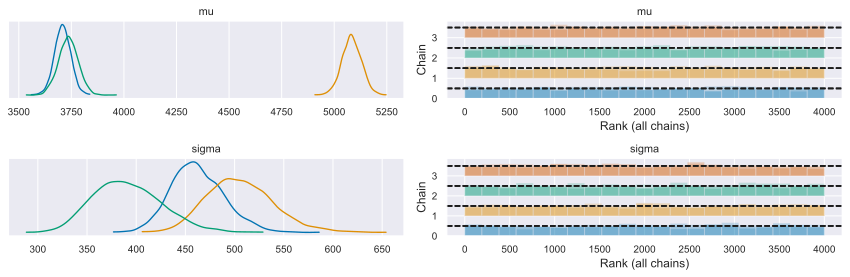

In [34]:
axes = az.plot_trace(
    labeled_idata, combined=True, divergences="bottom", kind="rank_bars"
)
plt.tight_layout()


Abbiamo ottenuto tre distribuzioni a posteriori per ciascuno dei due parametri $\mu$ e $\sigma$, una distribuzione per ciascuna specie di pinguini.

Esaminiamo se le quattro catene hanno prodotto risultati diversi per il parametro $\mu$.

Text(0.5, 1.0, 'μ Mass Estimate: 94.0% HDI')

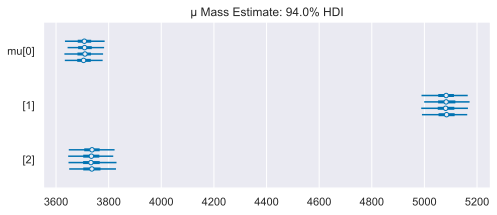

In [35]:
axes = az.plot_forest(labeled_idata, var_names=["mu"], figsize=(8, 3))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")


Facciamo la stessa cosa per il parametro $\sigma$.

Text(0.5, 1.0, 'σ Mass Estimate: 94.0% HDI')

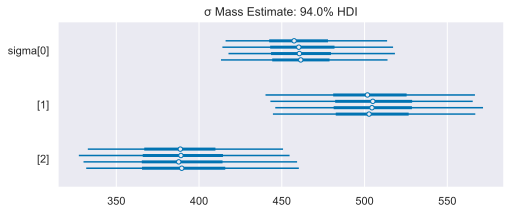

In [36]:
axes = az.plot_forest(labeled_idata, var_names=["sigma"], figsize=(8, 3))
axes[0].set_title("σ Mass Estimate: 94.0% HDI")


Un sommario numerico delle distribuzioni a posteriori si ottiene nel modo seguente.

In [37]:
az.summary(labeled_idata, kind="stats").round(2)


,mean,sd,hdi_3%,hdi_97%
mu[0],3707.94,39.02,3634.56,3780.39
mu[1],5083.31,46.61,4995.05,5171.08
mu[2],3735.14,46.87,3642.94,3820.61
sigma[0],462.06,26.96,413.68,515.00
sigma[1],505.63,33.99,443.08,567.89
sigma[2],391.07,34.73,332.22,458.88


Dalle distribuzioni a posteriori e dagli intervalli di credibilità, possiamo dedurre che il peso dei pinguini Adelie e Chinstrap è simile, mentre i pinguini Gentoo sono in genere più pesanti. Inoltre, l'analisi indica che il peso dei pinguini Gentoo ha una maggiore variabilità rispetto ai pinguini Adelie, seguita da quella dei pinguini Chinstrap. Al contrario, i pinguini Chinstrap mostrano una maggiore omogeneità nel peso.

## Verifica di ipotesi bayesiana

Una volta ottenuto un campione della distribuzione a priori del parametro di interesse $\mu$ per ciascuna delle tre specie di pinguini, possiamo chiederci quale sia la probabilità che il peso di un pinguino di una specie sia maggiore di quello di un pinguino di un'altra specie. Possiamo rispondere a questa domanda utilizzando un campione casuale della distribuzione a posteriori. Per fare ciò, dobbiamo confrontare il parametro di interesse per molti valori e calcolare la media dei valori trovati.

Per recuperare i valori numerici della distribuzione a posteriori del parametro $\mu$ dall'oggetto `labeled_idata`, possiamo utilizzare le funzioni di `ArviZ`. Esaminiamo le proprietà dell'oggetto `labeled_idata`.

In [33]:
labeled_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Recuperiamo i valori a posteriori del parametro $\mu$.

In [38]:
mu_post = labeled_idata.posterior['mu']

L'oggett ottenuto è un array di dimensioni $4 \times 1000 \times 3$. L'indice 4 si riferisce alle catente, l'indice 1000 si riferisce al numero di campioni ottenuti, l'indice 3 si riferisce ai gruppi. 

In [30]:
mu_post.shape

(4, 1000, 3)

Per trovare la media a posteriori del parametro $\mu$ della specie Adelie prendiamo le osservazioni che si riferiscono a tutte le catene (:), a tutti i valori campionati (:) per il primo gruppo (0). La media a posteriori dei pinguini Adelie è dunque uguale a

In [31]:
print(mu_post[:, :, 0].mean())

<xarray.DataArray 'mu' ()>
array(3707.93884115)
Coordinates:
    species  int64 0


Per tutte e tre le specie (Adelie, Gentoo, Chinstrap) abbiamo

In [39]:
np.array(
    [mu_post[:, :, 0].mean(), mu_post[:, :, 1].mean(), mu_post[:, :, 2].mean()]
).round(1)


array([3707.9, 5083.3, 3735.1])

In [40]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Per verificare che l'ordinamento dei gruppi corrisponda a Adelie, Gentoo, Chinstrap, esaminiamo la stima a posteriori della deviazione standard delle tre specie. 

In [41]:
sigma_post = labeled_idata.posterior["sigma"]
np.array(
    [sigma_post[:, :, 0].mean(), sigma_post[:, :, 1].mean(), sigma_post[:, :, 2].mean()]
).round(1)


array([462.1, 505.6, 391.1])

I valori trovati confermano quello che ci aspettavamo. Ora che abbiamo capito come estrarre le stime a posteriori di un parametro per ciascun gruppo, possiamo passare al test di ipotesi bayesiano.
Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Chinstrap.

In [42]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 2]])

0.66775

Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Gentoo.

In [43]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 2]])

0.66775

Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Gentoo.

In [44]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 1]])

1.0

Consideriamo ora le deviazioni standard. Troviamo la probabilità che la varianza del peso dei pinguini Adelie sia minore di quella dei pinguini Chinstrap.

In [45]:
np.mean([sigma_post[:, :, 2] > sigma_post[:, :, 0]])

0.05475

## Watermark

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat May 06 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

pytensor: 2.11.1

pandas    : 2.0.1
pymc      : 5.3.0
numpy     : 1.24.3
matplotlib: 3.7.1
seaborn   : 0.12.2
xarray    : 2023.4.2
arviz     : 0.15.1

Watermark: 2.3.1

